In [1]:
%load_ext autoreload
%autoreload 2

# Boltzmann distribution demo notebook
The notebook prepares a simulated energy profile and show the corresponding Boltzmann disribution from the theoretical equation and also by generating random particles following Boltzmann probability.

### Requirements
- numpy
- matplotlib

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

### 0. Functions

In [3]:
def calc_gauss(x, e, x0, s):
    ''' Calculate a Gaussian function as e * exp(-((x-x0)/s)²) output is a E in Kcal '''
    return e * np.exp(-(x-x0)**2 / s**2)

def calc_profile(ngauss, nstates, svalues, evalues):
    ''' Evaluates a the simulated profile and adding a series of Gaussian functions
        ngauss (int): Number of Gaussian functions
        nstates (int): Number of states to simulate
        svalues (int,int): range s values
        evalues (int,int): range e values (as 'RTs')
    '''
    RT = 1.987 * 298. / 1000. # Kcal/mol
    xvalues = (0, nstates - 1)
    xmin = 0.
    xmax = float(nstates - 1)
    
    random.seed()
    gauss = []
    for st in range(ngauss):
        gauss.append({
            'x' : random.randrange(xvalues[0], xvalues[1]),
            's' : random.randrange(svalues[0], svalues[1]),
            'e' : random.randrange(evalues[0], evalues[1])
        })

    # Adding the Wall functions, two additional half-gaussians centered at the ends of the plot
    # Fixed s at 10% of scale, and energy depending on the number of added gaussian 
    # functions. 
    wall_s = 0.1 * xmax
    wall_ef = 0.1 * ngauss
    
    gauss.append({'x' : xmin, 's' : wall_s, 'e': wall_ef * RT * evalues[1]})
    gauss.append({'x' : xmax, 's' : wall_s, 'e': wall_ef * RT * evalues[1]})
    
    # Adding the gaussian functions to get the final profile and averaging over ngauss to
    # set the energy on meaningful values
    energy_profile = {}
    
    for st in range(nstates):
        energy_profile[st] = 0.
        for gss in gauss:
            energy_profile[st] += calc_gauss(
                float(st), 
                RT * gss['e'], 
                gss['x'], 
                gss['s']
            ) / ngauss
    
    return energy_profile

def calc_boltzmann_term(e, T):
    ''' Calculate Boltzmann term as exp(-E/RT) '''
    R = 1.987/1000 # Kcal/K.mol
    return np.exp(-e/R/T)

### Initialize global values

In [4]:
nstates = 100      # number of states to represent
ngauss = 500       # number of gaussian functions to prepare the energy profile
evalues = (20, 80) # Rango for Energies (in 'RTs') for the gaussian functions
svalues = (2, 10)  # Range if widths (as std.devs) for the gaussian functions
T = 298            # temperature (K)
maxnparts = 100000 # Number of generated random particles
dt = 0.001         # Animation time update (set to a very lower value to be fast)

### 1. Prep energy profile

Prepared as a sum of random gaussian functions. Nstates define the x range (0, nstates-1), ngauss the number of Gaussian functions, evalues the range of energies and s the range of std. deviations.
Two additional functions are added at the ends of the range to give "funnel" shape to the landscape.
Skip this section when using a stored profile.

In [5]:
energy_profile = calc_profile(ngauss, nstates, svalues, evalues)

In [6]:
e_prof = np.array([np.linspace(0., nstates-1, num=nstates), list(energy_profile.values())])
np.save('e_profile', e_prof)

===========================================================================
### 1.1. Loading stored profile
After initialization, start here to re-use a previously stored profile. 

In [7]:
e_prof = np.load('e_profile.npy')

In [8]:
energy_profile = {i:e_prof[1][i] for i,v in enumerate(e_prof[1])}

### 2. Plotting the energy profile

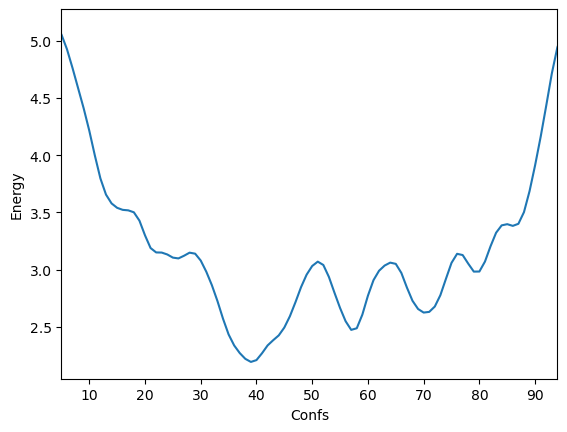

In [9]:
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(e_prof[0], e_prof[1])
ax.set_xlim(left=5, right=nstates-6)
ax.set_ylabel('Energy')
ax.set_xlabel('Confs')
plt.show()

### 3. Getting the Boltzmann population distribution
The theoretical distribution is calculated and plotted on top of the energy profile. 
Repeat from here for new Temperatures. 

In [10]:
boltz = {}
total_boltz = 0.
for st in energy_profile:
    boltz[st] = calc_boltzmann_term(energy_profile[st], T)
    total_boltz += boltz[st]

for st in boltz:
    boltz[st] /= total_boltz

btz_prof = np.array([np.linspace(0, nstates-1, num=nstates), list(boltz.values())])

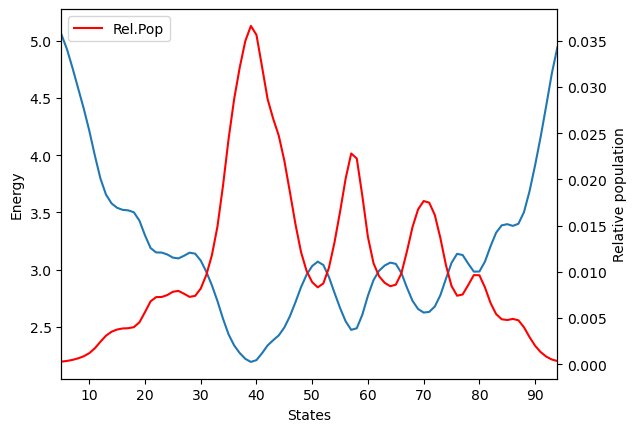

In [11]:
%matplotlib inline

fig, ax = plt.subplots()
ax.set_ylabel('Energy')
ax.set_xlabel('States')
ax.plot(e_prof[0], e_prof[1], label="Epot")
#Cutting ends to get a more realistic layout
ax.set_xlim(left=5, right=nstates-6)
#Adding Boltzmann population in secondary axis
ax2 = ax.twinx()
ax2.plot(btz_prof[0], btz_prof[1], label="Rel.Pop", color="red")
ax2.set_ylabel("Relative population")

plt.legend(loc='upper left')
plt.show()

### 4. Recapitulating distributions from the generation of random particles using Boltzmann probability density
maxnparts particles are being generated using the prob. distribution and population of states is plotted against energy and state. Note in next cell an easy way of getting random numbers with a given probability density. 

In [12]:
# Accumulating the probabilities normalized to the 0-1 interval in a single dict. 
# This trick is an easy way to map any probability distribution using a uniform random number
def get_energy_bin(acc_btz_prof, rn):
    ''' Maps a 0-1 value into a specific state. Simple trick to get random numbers with
        a given probability density.
        acc_btz_prof []: accumulated probability values, normalized to the 0-1 interval
        rn (float): random number
    '''
    st = 0
    while acc_btz_prof[st] < rn:
        st +=1
    return st

acc_btz = {}
acc_btz[0] = boltz[0]
for st in range(1, nstates):
    acc_btz[st] = acc_btz[st - 1] + boltz[st]
acc_btz_prof = np.array([np.linspace(0, nstates-1, num=nstates), list(acc_btz.values())])

In [15]:
%matplotlib

# calculating in chunks of "step" particles to speed-up
step = int(maxnparts/1000)

pop = {b : 0. for b in range(nstates)}

# two plots 1: Population distribution (should recover the Boltzmann distribution))
# 2: population of states, matched to the theoretical one

fig, ax = plt.subplots(1,2)

ax[1].set_xlabel('Confs')
ax[1].set_xlim(left=5, right=nstates-6)
ax[1].plot(e_prof[0], e_prof[1])
ax_xmin, ax_xmax, ax_ymin, ax_ymax = ax[1].axis()

ax3 = ax[1].twinx()

e_x = [energy_profile[b] for b in range(nstates)], 
        
for nparticles in range(0, maxnparts + 1, step):
    for _ in range(step):
        b = get_energy_bin(acc_btz, random.random())
        pop[b] += 1

    ax3.clear()
    ax3.set_ylabel("Norm population")
    ax3.scatter(
        btz_prof[0], 
        [pop[b]/(nparticles + 1) for b in range(nstates)],
        marker='.'
    )
    ax3_xmin, ax3_xmax, ax3_ymin, ax3_ymax = ax3.axis()
    
    ax[0].clear()
    ax[0].set_ylabel('Energy')
    ax[0].set_xlabel('Norm. Population')
    ax[0].scatter(
        [pop[b]/(nparticles + 1) for b in range(nstates)],
        e_x, 
        marker='.'
    )
    ax[0].set_title(f"T {T} K, Num. particles: {nparticles}")
    plt.pause(dt)
    
#Adding the theoretical profile
ax3_xmin, ax3_xmax, ax3_ymin, ax3_ymax = ax3.axis()
ax2 = ax[1].twinx()
ax2.set_ylim(ymin=ax3_ymin, ymax=ax3_ymax)
ax2.plot(btz_prof[0], btz_prof[1], color="red", label="Theory")
plt.pause(dt)
plt.legend()
plt.show()


Using matplotlib backend: QtAgg
